# Object Replacement Using stable diffusion

This script demonstrates:
- Loading a quantized model for image inpainting (Stable Diffusion 2 Inpainting).
- Automatically generating a mask for object replacement using a prompt.
- Using SAM (Segment Anything Model) for mask generation.
- Replacing the object in an image using a text-based prompt.
- Displaying the results.


In [1]:
# pip install diffusers
# pip install segment_anything

In [5]:
# Required imports
import torch
import numpy as np
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline
import cv2
from segment_anything import SamPredictor, sam_model_registry
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

In [2]:
device = 'cpu'
device

'cpu'

In [3]:
from kandinsky3 import get_inpainting_pipeline

In [6]:
device_map = torch.device('cpu')
dtype_map = {
    'unet': torch.float16,
    'text_encoder': torch.float16,
    'movq': torch.float32,
}

In [ ]:
pipe = get_inpainting_pipeline(
    device_map, dtype_map,
)

kandinsky3_inpainting.pt:   0%|          | 0.00/12.2G [00:00<?, ?B/s]

In [ ]:
# pipeline = StableDiffusionInpaintPipeline.from_pretrained(
#     "stabilityai/stable-diffusion-2-inpainting",
#     torch_dtype=torch.float32,
# ).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [7]:
# Load the Segment Anything Model (SAM)
model_path = 'sam_vit_h_4b8939.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sam = sam_model_registry['vit_h'](checkpoint=model_path)
sam.to(device)
predictor = SamPredictor(sam)

c:\Users\vishn\OneDrive\Desktop\GUI\creategui\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [8]:
# Load Grounding DINO model for prompt-based object detection
model_id = "IDEA-Research/grounding-dino-base"
processor = AutoProcessor.from_pretrained(model_id)
dino_model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

In [9]:
def get_bounding_box_from_prompt(image, prompt):
    """
    Uses the Grounding DINO model to get the bounding box for the given prompt.

    Args:
        image: The input image.
        prompt: The text prompt for the object to find.

    Returns:
        Bounding box (x_min, y_min, x_max, y_max) for the object.
    """
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for PIL

    # Grounding DINO requires lowercase text prompts ending with a period
    prompt = prompt.lower().strip() + '.'

    inputs = processor(images=pil_image, text=prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = dino_model(**inputs)

    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=0.4,
        text_threshold=0.3,
        target_sizes=[pil_image.size[::-1]]
    )

    if len(results) > 0 and 'boxes' in results[0]:
        # Use the box with the highest confidence score
        best_box_idx = 0  # Assuming the first box is the most relevant
        x_min, y_min, x_max, y_max = results[0]['boxes'][best_box_idx].tolist()
        return x_min, y_min, x_max, y_max
    else:
        print("No object found for the prompt.")
        return None

In [10]:
def create_segment_mask_from_box(image, box):
    """
    Create a segmentation mask using SAM for a given bounding box.

    Args:
        image: The input image.
        box: The bounding box (x_min, y_min, x_max, y_max) for the object.

    Returns:
        The binary mask for the segmented area.
    """
    x_min, y_min, x_max, y_max = map(int, box)
    center_x = (x_min + x_max) // 2
    center_y = (y_min + y_max) // 2
    input_point = np.array([[center_x, center_y]])  # Center of the bounding box
    input_label = np.ones(input_point.shape[0])

    predictor.set_image(image)

    masks, scores, logits = predictor.predict(
        point_coords=input_point, 
        point_labels=input_label,
        multimask_output=True  # This will generate multiple masks
    )

    best_mask_idx = np.argmax(scores)
    mask = masks[best_mask_idx]

    return mask

In [13]:
# Path to the input image
image_path = 'Images\image1.jpg'
prompt = 'dog'

In [14]:
# Load the image
image = cv2.imread(image_path)

# Resize image for better display if it's too large
height, width = image.shape[:2]
max_dimension = 512  # Maximum height or width
if max(height, width) > max_dimension:
    scale = max_dimension / max(height, width)
    image = cv2.resize(image, (int(width * scale), int(height * scale)))
# Get the bounding box for the object described in the prompt
print(f"Searching for '{prompt}' in the image...")
box = get_bounding_box_from_prompt(image, prompt)
print(f"Found bounding box: {box}")

# Generate the segmentation mask from the bounding box
mask = create_segment_mask_from_box(image, box)

Searching for 'dog' in the image...
Found bounding box: (245.7495574951172, 51.628822326660156, 439.6288757324219, 339.5440673828125)


In [15]:
# Resize the input image and mask for the pipeline
new_size = (512, 512)
image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)).resize(new_size)
mask = Image.fromarray((mask * 255).astype(np.uint8)).resize(new_size)

In [23]:
# Define the inpainting prompt
inpainting_prompt = "a cute cat is giving high-five"

# Perform inpainting using the pipeline
image = pipe( inpainting_prompt, image, mask)

  0%|          | 0/40 [00:00<?, ?it/s]

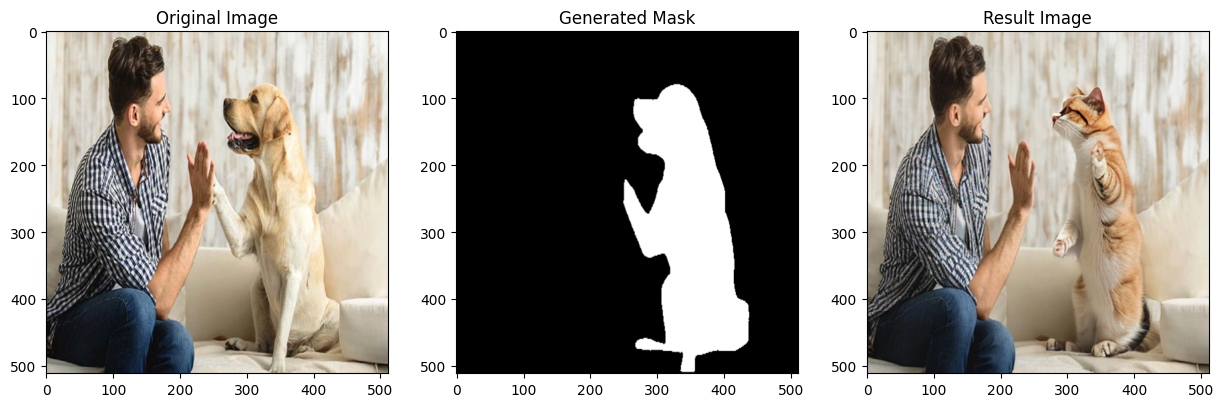

In [24]:
# Display the original image, mask, and result
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.title("Generated Mask")
plt.imshow(mask, cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Result Image")
plt.imshow(result.images[0])
plt.show()